# Spectral Unmixing Demo Notebook
Follow installation instructions step in README.md prior to running this demo

In [1]:
using Plots
using SpectralUnmixing
using Statistics

# Spectral Library Preparation

Start by loading up a spectral library, filtering it down to the desired classes, interpolating the spectra to the relevant wavelengths, and then removing undesired wavelength regions. By default the ignored regions correspond to atmospheric absorption regions. Here we split the library into the highest level classes: soil, photosynthetic vegetation (pv) and non-photosynthetic vegetation (npv). As the plots below show, all the endmember spectra within each class share general attributes while having small variations between them.

┌ Info: Ignoring wavelength regions: Any[[0, 440], [1310, 1490], [1770, 2050], [2440, 2880]]
└ @ SpectralUnmixing /Users/jhalani/Documents/EMIT-SDS/SpectralUnmixing/src/EndmemberLibrary.jl:110


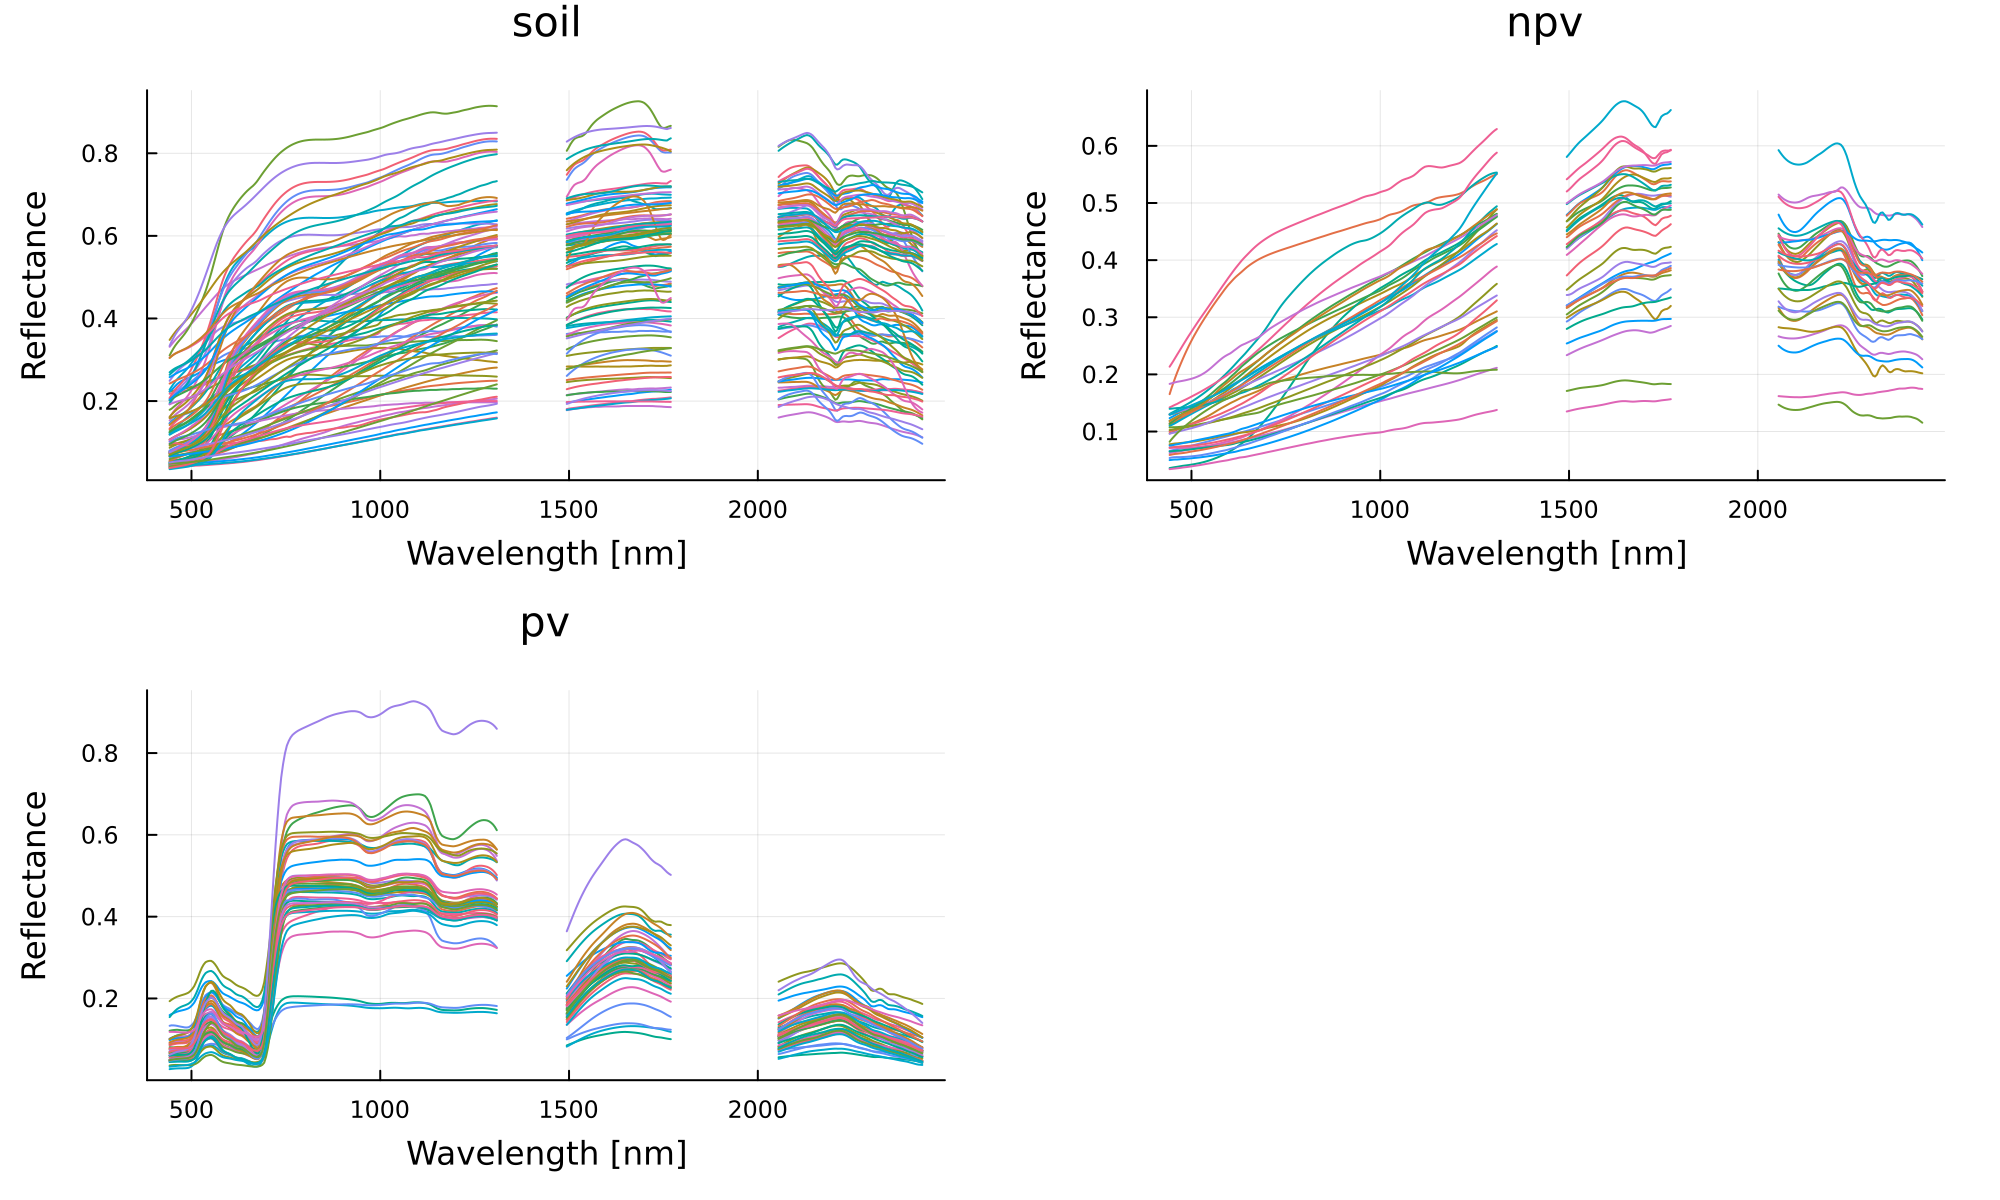

In [2]:
endmember_library = SpectralLibrary("convex_hull__n_dims_4_unmix_library.csv", "level_1", 8, 0, ["soil","npv","pv"]);
load_data!(endmember_library);
filter_by_class!(endmember_library);

refl_file_wl = read_envi_wavelengths("fake_refl");
interpolate_library_to_new_wavelengths!(endmember_library, refl_file_wl);

# fill the ignored regions with NaNs to improve visualization of the endmember spectra.
remove_wavelength_region_inplace!(endmember_library, true);

plot_endmembers_individually(endmember_library)
plot!(margin=5Plots.mm)


## Simulation and Unmixing Library Setup

Split the endmember library into training and testing sets using `split_library()`. This function randomly allocates a fraction of endmembers from each class to one library and the remaining endmembers in another. Here we split the library in half using a fraction of `0.5`.

In [3]:
full_el = deepcopy(endmember_library)
# remove the ignored regions entirely instead of filling with NaNs to improve computational efficiency.
remove_wavelength_region_inplace!(full_el, false);

simulation_library, unmixing_library = split_library(full_el, 0.5);

# Simulate spectra

Now that we have a simulation and unmixing library, let's simulate a spectrum that we will subsequently retrieve.

The `simulate_pixel()` function is used below to create a simulated reflectance from 3 endmember components randomly chosen evenly from each class from the simulation library. For this example we'll use the "class-even" combination type which ensures at least one endmember from each class is chosen.

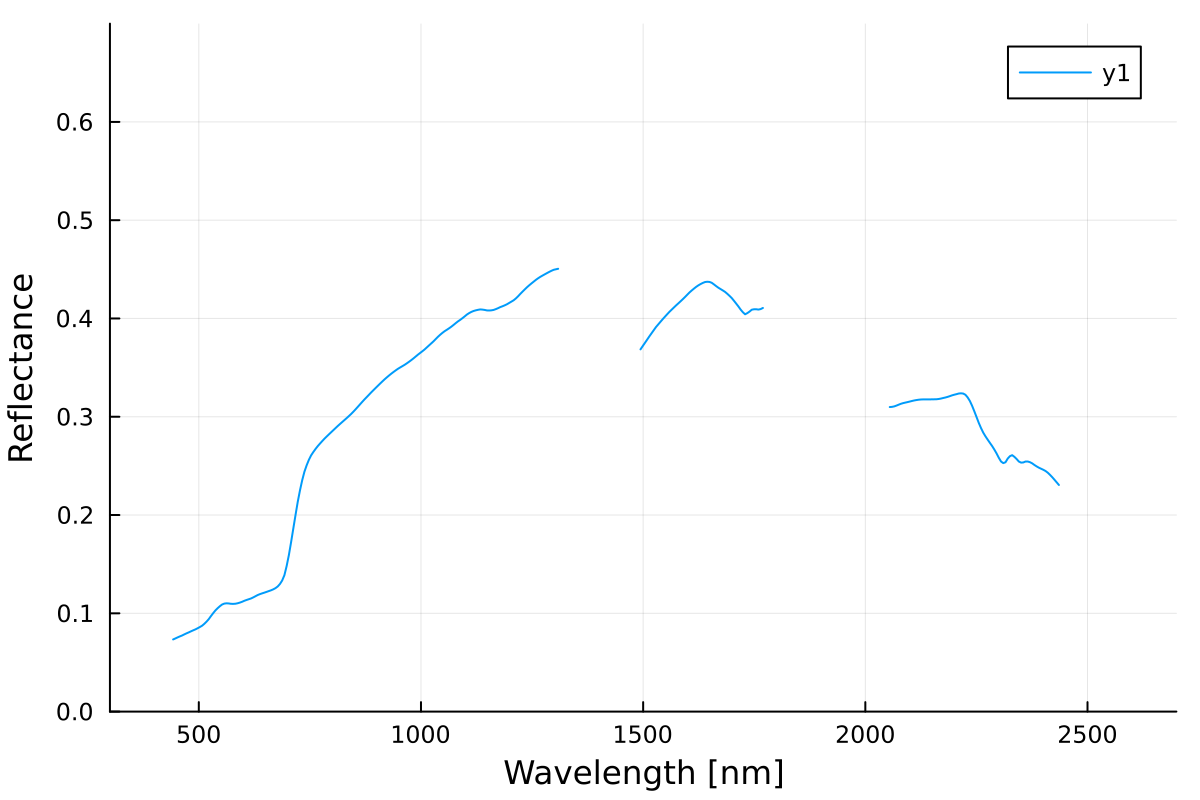

In [20]:
simulated_rfl, tcf, tmf = simulate_pixel(simulation_library, 3, "class-even", 13)
simulated_rfl = reshape(simulated_rfl, (1, size(simulated_rfl)[1]))

full_rfl = ones(size(endmember_library.wavelengths))
full_rfl[endmember_library.good_bands] = simulated_rfl[1,:]
plot(endmember_library.wavelengths, full_rfl, xlim=[300,2700])

xlabel!("Wavelength [nm]")
ylabel!("Reflectance")
xticks!([500, 1000, 1500, 2000, 2500])
ylims!(0,0.7)
plot!(dpi=200)
plot!()


# A Single SMA Unmixing Case
Run one unmixing case to size up the outputs and make sure things work. Unmixing is done using a Monte Carlo (MC) method where endmembers are chosen at random to construct the unmixing matrices using two main approaches: spectral mixture analysis (SMA) and multiple-endmember spectral mixture analysis (MESMA).

There are a few options that must be set for unmixing, including the number of MC loops, the unmixing mode (`"sma-best"` here corresponds to SMA and using the lowest cost solution from MC), number of endmembers, the normalization mode, and optimization mode. After the prep steps, the single function `unmix_pixel()` performs the MC matrix inversions and outputs the unmixing results.

See Ochoa et al. (in preparation) for more info on different unmixing techniques and options.

In [21]:
n_mc = 25
mode = "sma-best"
num_endmembers=[30]
normalization="brightness"
optimization="bvls"

max_combinations=100
combination_type="class-even"

class_idx = prepare_combinations(unmixing_library, combination_type)
options = prepare_options(unmixing_library, combination_type, num_endmembers, class_idx)

mr, mv, cfr, cfv = unmix_pixel(unmixing_library, simulated_rfl, nothing,
                               class_idx, 	options, mode, n_mc,
                               num_endmembers, normalization, optimization,
                               max_combinations, combination_type);

# outputs are one element longer because brightness is appended
brightness = mr[end]
println("Brightness: $(round((brightness*100), digits=2)) %")
for (class, result) in zip(unmixing_library.class_valid_keys, mr[1:end-1])
    println("$class fraction: $(round(result*100,digits=2)) %")
end

Brightness: 33.44 %
soil fraction: 43.61 %
npv fraction: 27.39 %
pv fraction: 29.0 %


The mixture results can also be used to reconstruct the pixel spectrum and compare to our simulation:

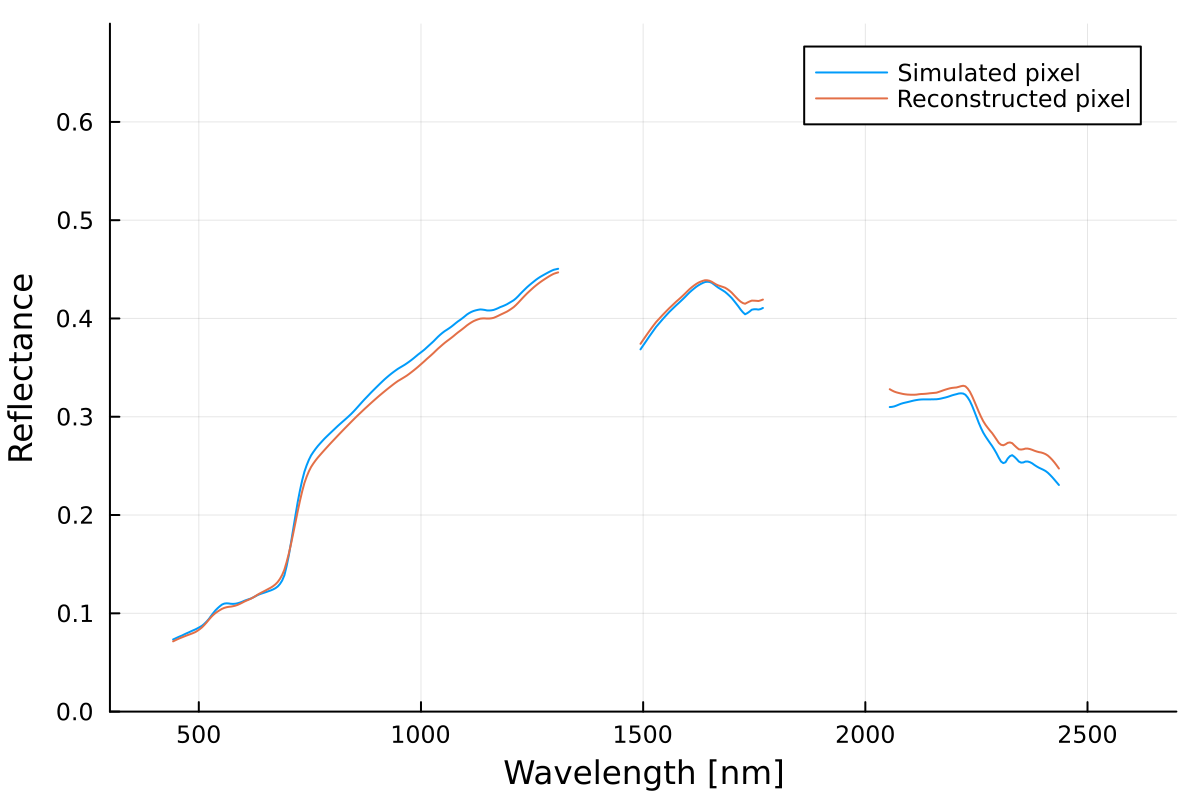

In [25]:
cfr2 = cfr[1:end-1]
cfrt = reshape(cfr2, (1, size(cfr2)[1]))
mod_rfl = cfrt * unmixing_library.spectra

mod_full_rfl = ones(size(endmember_library.wavelengths))
mod_full_rfl[endmember_library.good_bands] = mod_rfl[1,:]
plot(endmember_library.wavelengths, [full_rfl, mod_full_rfl], xlim=[300,2700], label=["Simulated pixel" "Reconstructed pixel"])

xlabel!("Wavelength [nm]")
ylabel!("Reflectance")
xticks!([500, 1000, 1500, 2000, 2500])
ylims!(0,0.7)
plot!(dpi=200)
plot!()

# Unmixing Ensemble

We can now run the simulation and pixel fraction retrieval for an ensemble of unmixing cases to look at the computational and retrieval performance of the spectral analysis using parameters we chose.

In [17]:
num_instances = 100
mixture_results = zeros(num_instances, size(mr)[1])
comp_frac_results = zeros(num_instances, size(cfr)[1])
simulated_mixtures = zeros(num_instances, size(tmf)[1])

start_time = time()
for idx in 1:num_instances
    simulated_rfl, tcf, tmf = simulate_pixel(simulation_library, 3, "class-even", idx)
    simulated_rfl = reshape(simulated_rfl, (1, size(simulated_rfl)[1]))

    mr, mv, cfr, cfv = unmix_pixel(unmixing_library, simulated_rfl, nothing, class_idx,
    							   options, mode, n_mc, num_endmembers, normalization, 								   optimization, max_combinations, combination_type)

    mixture_results[idx,:] = mr
    comp_frac_results[idx,:] = cfr
    simulated_mixtures[idx,:] = tmf

end
end_time = time()

println("Spectra per second: ", num_instances / (end_time - start_time))

Spectra per second: 17.73701857676367


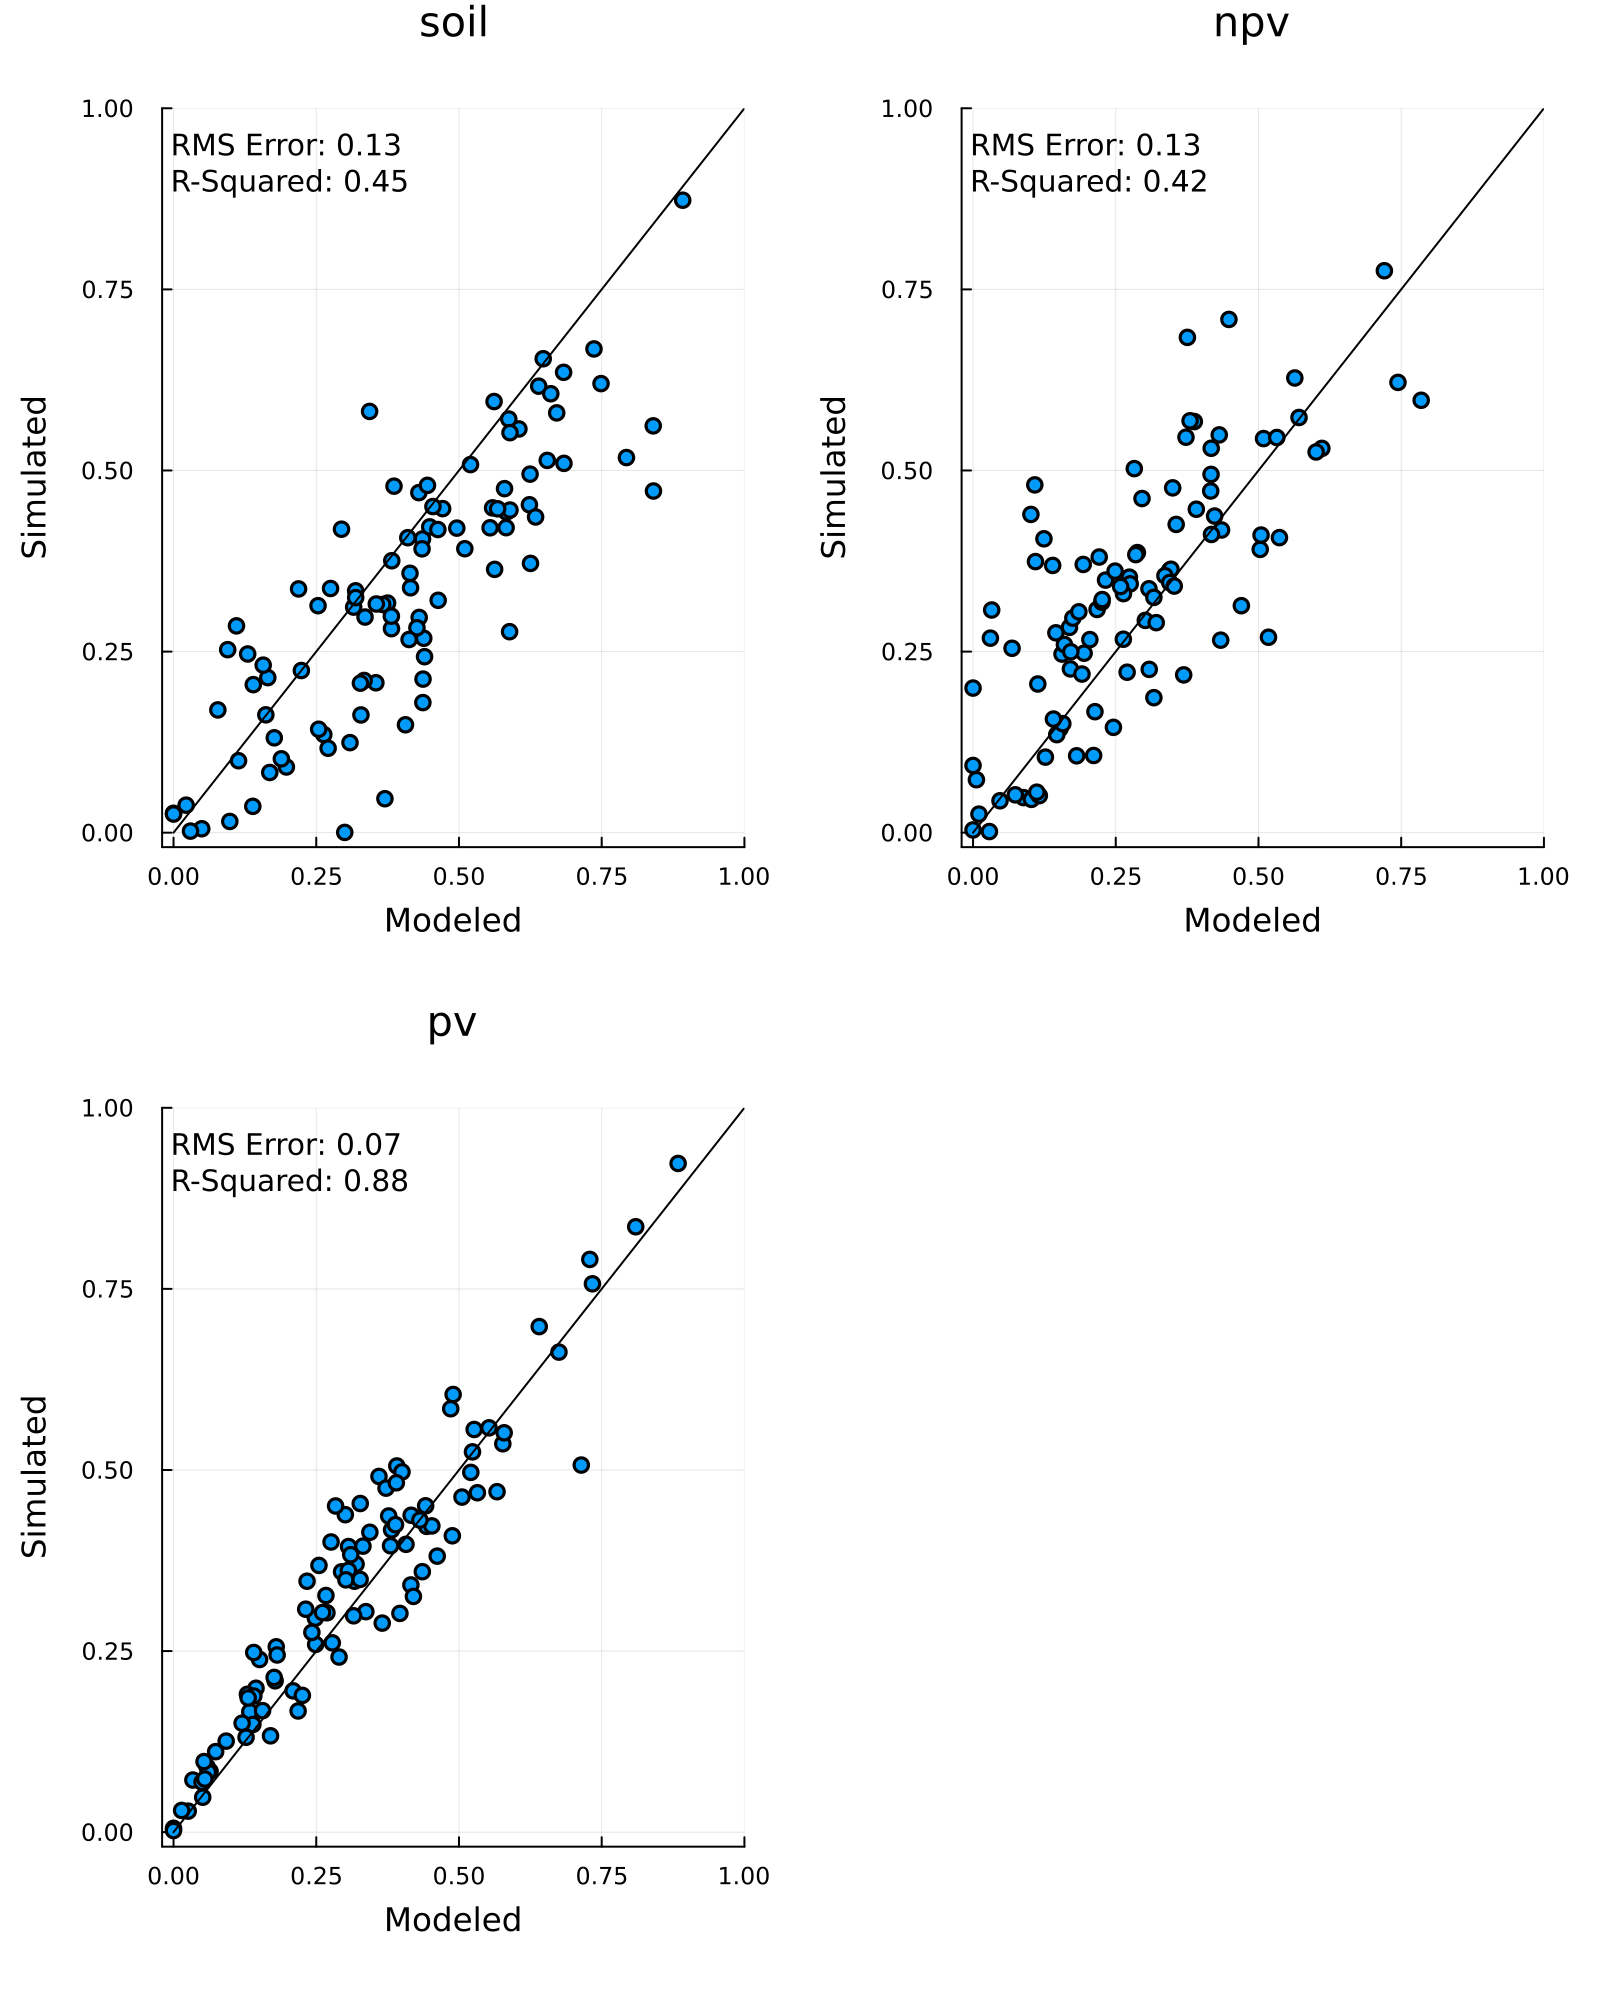

In [26]:
plots = []
# add x-y line
for _u in 1:(size(mr)[1] - 1)
    p = plot(mixture_results[:,_u], simulated_mixtures[:,_u],
        seriestype = :scatter, title=unmixing_library.class_valid_keys[_u],
        xlabel="Modeled", ylabel="Simulated", legend=false)
    # R2 around the 1-1 line, not against the linear trend line (bias sensitive)
    r2 = round(1 - sum( (simulated_mixtures[:,_u] - mixture_results[:,_u]).^2 )
                /  sum( (simulated_mixtures[:,_u]
                .- mean(simulated_mixtures[:,_u])).^2 ),
                digits=2)
    rmse = round(sqrt(mean((simulated_mixtures[:,_u]
                            - mixture_results[:,_u]).^2)),
                digits=2)
    annotate!(0,0.9,text("R-Squared: " * string(r2),:left, 10))
    annotate!(0,0.95,text("RMS Error: " * string(rmse),:left, 10))
    xlims!(-0.02,1)
    ylims!(-0.02,1)
    push!(plots, p)
end
for plot in plots
    plot!(plot, [0, 1], [0, 1], linecolor = :black)
end
plot(plots...,size=(800,1000),dpi=200)
plot!(margin=5Plots.mm)